                            OLS Regression Results                            
Dep. Variable:                MedCost   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     253.6
Date:                Wed, 28 Feb 2024   Prob (F-statistic):               0.00
Time:                        10:25:55   Log-Likelihood:                -22843.
No. Observations:                3000   AIC:                         4.570e+04
Df Residuals:                    2991   BIC:                         4.576e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

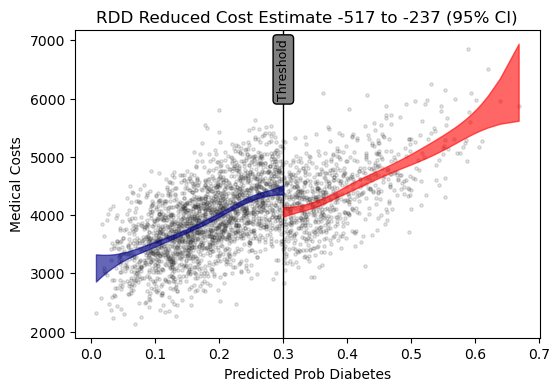

In [10]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

########################################
# Simulating data
np.random.seed(10)
n_cases = 3000 # total number of cases
# pretend this is predicted prob
prob = np.random.beta(3,10,size=n_cases)
# pretend this is med costs over a year
med_cost = 3000 + 5000*prob + -500*(prob > 0.3) + np.random.normal(0,500,n_cases)
df = pd.DataFrame(zip(prob,med_cost), columns=['Prob','MedCost'])
# could do something fancier with non-linear effects for prob
########################################

########################################
# Fitting regression model

# Knots are small distance from threshold
# (Could also do a knot right on threshold)
mod = smf.ols(formula='MedCost ~ bs(Prob,knots=[0.2,0.25,0.35,0.4]) + I(Prob > 0.3)', data=df)
res = mod.fit()
print(res.summary())
########################################

########################################
# Plotting fit

# Getting standard errors
prob_se = res.get_prediction().summary_frame()
prob_se['Prob'] = prob
prob_se.sort_values(by='Prob',inplace=True,ignore_index=True)
low = prob_se[prob_se['Prob'] <= 0.3].copy()
high = prob_se[prob_se['Prob'] > 0.3].copy()

# Getting effect for threshold bump
coef = res.summary2().tables[1]
ci = coef.iloc[1,4:6].astype(int).to_list()

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(df['Prob'], df['MedCost'], c='grey',
           edgecolor='k', alpha=0.15, s=5, zorder=1)
ax.axvline(0.3, linestyle='solid', alpha=1.0, 
           color='k',linewidth=1, zorder=2)
ax.fill_between(low['Prob'],low['mean_ci_lower'],
                low['mean_ci_upper'],alpha=0.6,
                zorder=3, color='darkblue')
ax.fill_between(high['Prob'],high['mean_ci_lower'],
                high['mean_ci_upper'],alpha=0.6,
                zorder=3, color='red')
ax.set_xlabel('Predicted Prob Diabetes')
ax.set_ylabel('Medical Costs')
ax.set_title(f'RDD Reduced Cost Estimate {ci[0]} to {ci[1]} (95% CI)')
ax.text(0.3,6500,'Threshold',rotation=90, size=9,
         ha="center", va="center",
         bbox=dict(boxstyle="round", ec='k',fc='grey'))
plt.savefig('RDD.png', dpi=500, bbox_inches='tight')
########################################

<Axes: xlabel='MedCost', ylabel='Prob'>

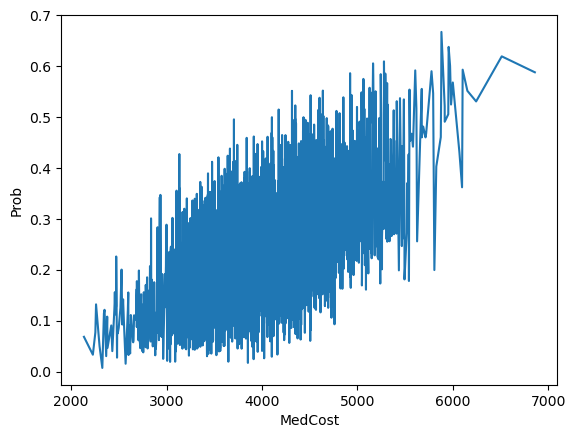

In [11]:
sns.lineplot(x='MedCost', y='Prob', data=df)